<a href="https://colab.research.google.com/github/aLehav/MLVideoDescriptionResearch/blob/main/BEATs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Link to BEATs Github](https://github.com/microsoft/unilm/tree/master/beats)

[Link to AudioSet](https://ieeexplore-ieee-org.libproxy2.usc.edu/stamp/stamp.jsp?tp=&arnumber=7952261)

In [1]:
!pip install boto3 --quiet
import io
import pandas as pd
import math
import cv2
import torch
import torchaudio
import json
import os
import tarfile
import tempfile
import boto3
import matplotlib.pyplot as plt
import requests
from botocore import UNSIGNED
from botocore.config import Config
from IPython.display import Audio
!git clone https://github.com/microsoft/unilm.git --quiet
%cd unilm/beats
from Tokenizers import TokenizersConfig, Tokenizers
from BEATs import BEATs, BEATsConfig
%cd ../../
!git clone https://github.com/audioset/ontology.git --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 13.6 MB/s eta 0:00:00
/content/unilm/beats
/content


In [2]:
%cd ontology
f = open('ontology.json')
ontology = json.load(f)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd ../drive/MyDrive/video_summarization/
!ls

/content/ontology
Mounted at /content/drive
/content/drive/MyDrive/video_summarization
91IHQYk1IQM.mp3					 ontology
91IHQYk1IQM.mp4					 qqR6AEXwxoQ.mp3
91IHQYk1IQM.wav					 qqR6AEXwxoQ.wav
BEATs_iter3_plus_AS2M_finetuned_on_AS2M_cpt2.pt  Tokenizer_iter3_plus_AS2M.pt
BEATs_iter3_plus_AS2M.pt			 ydata-tvsum50-anno.tsv


In [3]:
# print(torchaudio.info("qqR6AEXwxoQ.wav"))
meta = torchaudio.info('91IHQYk1IQM.wav')
num_frames = meta.num_frames
waveform, sample_rate = torchaudio.load("91IHQYk1IQM.wav")
print(waveform.shape)

torch.Size([1, 1768432])


In [4]:
scaler = 2*sample_rate
i_range = range(math.ceil(num_frames/scaler))
def bot_slice(i):
  return i*scaler
def top_slice(i):
  return min((i+1)*scaler, num_frames)
waveforms = [waveform[:,bot_slice(i):top_slice(i)] for i in i_range]
# for wave in waveforms:
  # print(wave.shape)

In [5]:
audio_input_16khz = waveforms
inputs = len(waveforms)
length_per_input = scaler
# print(waveform.shape[1])
# len = audio_input_16khz.shape[1]
padding_mask = torch.zeros(inputs,length_per_input).bool()

In [6]:
print(len(waveforms))
print(waveforms[0].shape[1])

56
32000


In [7]:
# checkpoint = torch.load('Tokenizer_iter3_plus_AS2M.pt')
# checkpoint = torch.load('BEATs_iter3_plus_AS2M.pt')
checkpoint = torch.load('BEATs_iter3_plus_AS2M_finetuned_on_AS2M_cpt2.pt')

In [8]:
#for fine-tuned
cfg = BEATsConfig(checkpoint['cfg'])
BEATs_model = BEATs(cfg)
BEATs_model.load_state_dict(checkpoint['model'])
# BEATs_model.eval()  

<All keys matched successfully>

In [9]:
# probs = BEATs_model.extract_features(audio_input_16khz, padding_mask=padding_mask)[0]
def get_top_k_labels(audio_input_16khz, k):
  audio_length = audio_input_16khz.shape[1]
  audio_dim = audio_input_16khz.shape[0]
  padding_mask = torch.zeros(audio_dim,audio_length).bool()

  probs = BEATs_model.extract_features(audio_input_16khz, padding_mask=padding_mask)[0]
  for i, (top5_label_prob, top5_label_idx) in enumerate(zip(*probs.topk(k=k))):
      top5_label = [checkpoint['label_dict'][label_idx.item()] for label_idx in top5_label_idx]
      return (top5_label, top5_label_prob)
labels = [get_top_k_labels(wave, 5) for wave in waveforms]
print(labels)
  

[(['/m/04rlf', '/m/07y_7', '/m/04szw', '/m/0l14_3', '/m/0ggq0m'], tensor([0.8434, 0.4537, 0.2909, 0.1306, 0.0477], grad_fn=<UnbindBackward0>)), (['/m/04rlf', '/m/04szw', '/m/02p0sh1', '/m/07y_7', '/m/0ggq0m'], tensor([0.7971, 0.2541, 0.1872, 0.1700, 0.1124], grad_fn=<UnbindBackward0>)), (['/m/04rlf', '/m/0192l', '/m/04szw', '/m/085jw', '/m/09x0r'], tensor([0.5657, 0.3333, 0.1807, 0.1337, 0.0740], grad_fn=<UnbindBackward0>)), (['/m/04rlf', '/m/04szw', '/m/07y_7', '/m/02p0sh1', '/m/015vgc'], tensor([0.8818, 0.4012, 0.2938, 0.2343, 0.2293], grad_fn=<UnbindBackward0>)), (['/m/04rlf', '/m/01kcd', '/m/04szw', '/m/07gql', '/m/01wy6'], tensor([0.7175, 0.3785, 0.3156, 0.2911, 0.1428], grad_fn=<UnbindBackward0>)), (['/m/04rlf', '/m/07y_7', '/m/04szw', '/m/0ggq0m', '/m/0l14_3'], tensor([0.8274, 0.6584, 0.5081, 0.1491, 0.1158], grad_fn=<UnbindBackward0>)), (['/m/04rlf', '/m/0192l', '/m/02p0sh1', '/m/04szw', '/m/085jw'], tensor([0.7876, 0.4536, 0.4494, 0.1504, 0.1416], grad_fn=<UnbindBackward0>)), 

In [10]:
label_set = [label[0] for label in labels]
def ont_index (label):
  return next((i for i, item in enumerate(ontology) if item['id'] == label), -1)
a = lambda x: [ontology[ont_index(i)]['name'] for i in x]
english_label_set = [a(label) for label in label_set]
df = pd.DataFrame(english_label_set)
df

,0,1,2,3,4
0,Music,"Violin, fiddle",Musical instrument,Bowed string instrument,Classical music
1,Music,Musical instrument,Traditional music,"Violin, fiddle",Classical music
2,Music,Bagpipes,Musical instrument,"Wind instrument, woodwind instrument",Speech
3,Music,Musical instrument,"Violin, fiddle",Traditional music,Carnatic music
4,Music,Brass instrument,Musical instrument,Trumpet,Clarinet
5,Music,"Violin, fiddle",Musical instrument,Classical music,Bowed string instrument
6,Music,Bagpipes,Traditional music,Musical instrument,"Wind instrument, woodwind instrument"
7,Music,Musical instrument,Trumpet,Traditional music,Brass instrument
8,Music,"Wind instrument, woodwind instrument",Musical instrument,Speech,Trumpet
9,Music,Speech,Singing,Shout,Musical instrument


In [11]:
vid_id = '91IHQYk1IQM'
cap = cv2.VideoCapture(vid_id+'.mp4')
fps = cap.get(cv2.CAP_PROP_FPS)
print(fps)

29.97002997002997


In [12]:
anno = pd.read_csv('ydata-tvsum50-anno.tsv', sep='\t', header=None)
vid_anno = anno.loc[anno[0] == vid_id]
def annotation_string_to_numerics(vid_anno):
  a = lambda x: [int(i) for i in x[1][2].split(',')]
  return pd.DataFrame([a(annotation) for annotation in vid_anno.iterrows()])
ratings = annotation_string_to_numerics(vid_anno)

<AxesSubplot:>

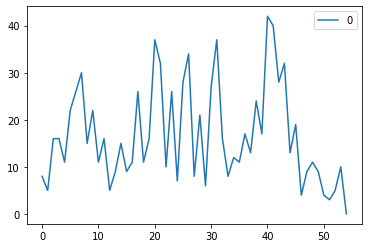

In [61]:
scaler = 2*fps
i_range = range(1,math.ceil(ratings.shape[1]/scaler))
def bot_slice(i):
  return int(i*scaler)
# def top_slice(i):
  # return min((i+1)*scaler, ratings.shape[1])

scorer = lambda i: sum(abs(ratings[bot_slice(i)] - ratings[bot_slice(i)+1]))

score_changes = pd.DataFrame([scorer(i) for i in i_range])
score_changes.plot()

In [56]:
a = lambda ind: pd.Series(df.iloc[ind])
b = lambda ind: len(a(ind)) - sum([(item in a(ind+1).unique()) for item in a(ind)]) 
def label_changes(df):
  return pd.DataFrame([b(i) for i in range(df.shape[0]-1)])
lab_changes = label_changes(df)

<AxesSubplot:>

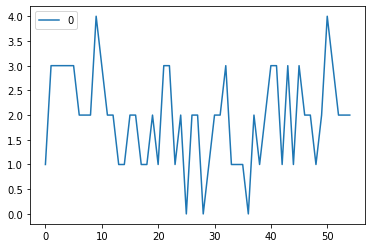

In [57]:
lab_changes.plot()

In [67]:
changes = pd.concat([score_changes, lab_changes], axis=1)
changes.columns = ['Score','Labels']

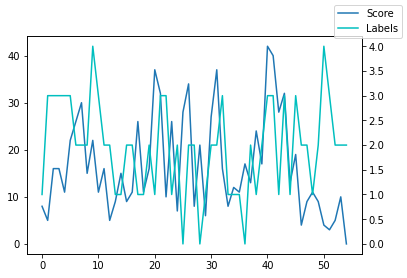

In [101]:
import matplotlib.pyplot as plt

ax = changes.plot(y="Score", legend=False)
ax2 = ax.twinx()
changes.plot(y="Labels", ax=ax2, legend=False, color="c")
ax.figure.legend()
plt.show()